In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("df.csv")

# Convert date column
df["CreatedOn"] = pd.to_datetime(df["CreatedOn"])

df.head()


,Unnamed: 0,Dist Name,Pest,CreatedOn,pest_count,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0,24 parganas (NORTH DISTRICT),aphid,2013-05-08,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,24 parganas (NORTH DISTRICT),aphid,2013-11-06,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,24 parganas (NORTH DISTRICT),aphid,2013-11-11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,24 parganas (NORTH DISTRICT),aphid,2013-11-25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,24 parganas (NORTH DISTRICT),aphid,2013-12-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df["CreatedOn"] = pd.to_datetime(df["CreatedOn"])
df.head()

,Unnamed: 0,Dist Name,Pest,CreatedOn,pest_count,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0,24 parganas (NORTH DISTRICT),aphid,2013-05-08,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,24 parganas (NORTH DISTRICT),aphid,2013-11-06,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,24 parganas (NORTH DISTRICT),aphid,2013-11-11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,24 parganas (NORTH DISTRICT),aphid,2013-11-25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,24 parganas (NORTH DISTRICT),aphid,2013-12-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check unique values to ensure correct spelling
print("Sample Districts:", df["Dist Name"].unique()[:10])
print("Sample Pests:", df["Pest"].unique()[:10])

# Update the district name based on the printed samples
district = "24 parganas (NORTH DISTRICT)"
pest = "aphid"

filtered_df = df[
    (df["Dist Name"] == district) &
    (df["Pest"] == pest)
]

print(f"\nFiltered Data Shape: {filtered_df.shape}")
if filtered_df.empty:
    print("WARNING: Filtered data is empty! Check the spelling of district and pest.")

Sample Districts: <ArrowStringArray>
['24 parganas (NORTH DISTRICT)', '24 parganas (SOUTH DISTRICT)',
                     'ADILABAD',                         'AGRA',
                    'AHMADABAD',                   'AHMADNAGAR',
                        'AJMER',                        'AKOLA',
                    'ALAPPUZHA',                      'ALIGARH']
Length: 10, dtype: str
Sample Pests: <ArrowStringArray>
[           'aphid',         'armyworm',        'ashweevil',
         'backmoth',           'beetle',            'borer',
 'brownplanthopper',              'bug',      'caterpiller',
          'cutworm']
Length: 10, dtype: str

Filtered Data Shape: (135, 12)


In [6]:
ts = (
    filtered_df
    .set_index("CreatedOn")
    .resample("ME")["pest_count"]
    .sum()
)

ts.head()

CreatedOn
2013-05-31    1
2013-06-30    0
2013-07-31    0
2013-08-31    0
2013-09-30    0
Freq: ME, Name: pest_count, dtype: int64

In [7]:
# preprocessing.py

import pandas as pd
import numpy as np

def create_supervised_data(ts, n_lags=12):
    df = pd.DataFrame(ts)
    df.columns = ["target"]

    for lag in range(1, n_lags + 1):
        df[f"lag_{lag}"] = df["target"].shift(lag)

    df = df.dropna()
    return df


def train_test_split_time(df, split_ratio=0.8):
    train_size = int(len(df) * split_ratio)

    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    X_train = train.drop("target", axis=1)
    y_train = train["target"]

    X_test = test.drop("target", axis=1)
    y_test = test["target"]

    return X_train, X_test, y_train, y_test


In [8]:
# train_models.py

import joblib

def train_model(model, X_train, y_train, model_name):
    model.fit(X_train, y_train)

    # Save trained model
    joblib.dump(model, f"models/{model_name}.pkl")

    print(f"{model_name} trained and saved successfully.")
    return model


In [9]:
from sklearn.ensemble import RandomForestRegressor

def get_model():
    return RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42
    )


In [10]:
# evaluate_visualize.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_model(model, X_test, y_test):

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("RMSE:", rmse)
    print("MAE :", mae)
    print("R2  :", r2)

    return y_pred


def plot_actual_vs_predicted(y_test, y_pred, title):

    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test, label="Actual")
    plt.plot(y_test.index, y_pred, label="Predicted")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_feature_importance(model, feature_names):

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

        plt.figure(figsize=(8,5))
        plt.bar(feature_names, importances)
        plt.xticks(rotation=45)
        plt.title("Feature Importance")
        plt.show()


def plot_residuals(y_test, y_pred):

    residuals = y_test - y_pred

    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals)
    plt.axhline(0)
    plt.title("Residual Plot")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.show()


In [11]:
# 1. Create supervised data
supervised_df = create_supervised_data(ts, n_lags=12)

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split_time(supervised_df)

# 3. Get and Train Model
model = get_model()
model = train_model(model, X_train, y_train, "RandomForest")

# 4. Evaluate
y_pred = evaluate_model(model, X_test, y_test)

# 5. Visualize
plot_actual_vs_predicted(y_test, y_pred, "Random Forest Forecast")

# 6. Feature Importance (optional)
plot_feature_importance(model, X_train.columns)

FileNotFoundError: [Errno 2] No such file or directory: 'models/RandomForest.pkl'

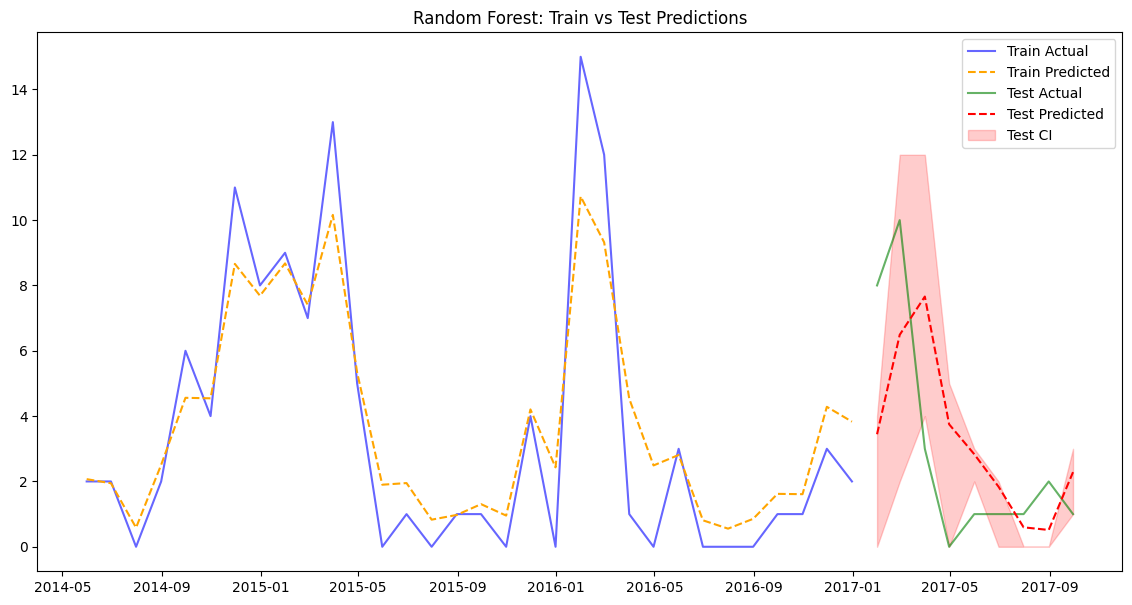

In [ ]:
# 7. Plot Training vs Testing data with Confidence Intervals

# Function to calculate prediction intervals
def get_prediction_intervals(model, X, percentile=95):
    # Get predictions from all individual trees
    all_tree_preds = np.stack([tree.predict(X) for tree in model.estimators_], axis=0)
    
    # Calculate lower and upper bounds
    lower = np.percentile(all_tree_preds, (100 - percentile) / 2, axis=0)
    upper = np.percentile(all_tree_preds, 100 - (100 - percentile) / 2, axis=0)
    
    return lower, upper

# Get predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test) 

# Get intervals (Only for Test Data)
# Reducing to 50% confidence interval (Interquartile Range) for a tighter band
confidence_level = 50
lower_test, upper_test = get_prediction_intervals(model, X_test, percentile=confidence_level)

plt.figure(figsize=(14, 7))

# Plot Training Data (No CI)
plt.plot(y_train.index, y_train, label="Train Actual", color='blue', alpha=0.6)
plt.plot(y_train.index, y_train_pred, label="Train Predicted", color='orange', linestyle='--')

# Plot Testing Data (With CI)
plt.plot(y_test.index, y_test, label="Test Actual", color='green', alpha=0.6)
plt.plot(y_test.index, y_test_pred, label="Test Predicted", color='red', linestyle='--')
plt.fill_between(y_test.index, lower_test, upper_test, color='red', alpha=0.2, label=f"Test CI")

plt.title("Random Forest: Train vs Test Predictions")
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def get_model():
    return AdaBoostRegressor(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    )


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def get_model():
    return GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    )


In [ ]:
from sklearn.ensemble import BaggingRegressor

def get_model():
    return BaggingRegressor(
        n_estimators=200,
        random_state=42
    )


In [ ]:
from xgboost import XGBRegressor

def get_model():
    return XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )


In [ ]:
# run_experiment.py

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_prediction_intervals_ensemble(model, X, percentile=90):
    """
    Get prediction intervals. 
    1. For Forest/Bagging: Use the distribution of individual tree predictions.
    2. For Boosting/Others: Return None (will use fallback approximation).
    """
    try:
        if hasattr(model, "estimators_") and len(model.estimators_) > 0:
            # Check if it's a bagging-style ensemble (parallel estimators)
            name = model.__class__.__name__
            if "RandomForest" in name or "Bagging" in name:
                all_tree_preds = np.stack([tree.predict(X) for tree in model.estimators_], axis=0)
                lower = np.percentile(all_tree_preds, (100 - percentile) / 2, axis=0)
                upper = np.percentile(all_tree_preds, 100 - (100 - percentile) / 2, axis=0)
                return lower, upper

        return None, None
        
    except Exception as e:
        return None, None

def plot_full_comparison_with_ci(y_train, y_train_pred, y_test, y_test_pred, lower_test, upper_test, title):
    plt.figure(figsize=(14, 7))

    # Plot Training Data
    plt.plot(y_train.index, y_train, label="Train Actual", color='blue', alpha=0.6)
    plt.plot(y_train.index, y_train_pred, label="Train Predicted", color='orange', linestyle='--')

    # Plot Testing Data
    plt.plot(y_test.index, y_test, label="Test Actual", color='green', alpha=0.6)
    plt.plot(y_test.index, y_test_pred, label="Test Predicted", color='red', linestyle='--')
    
    # Plot CI 
    if lower_test is not None and upper_test is not None:
         # Case 1: Model provided specific intervals (RandomForest/Bagging)
         plt.fill_between(y_test.index, lower_test, upper_test, color='red', alpha=0.2, label="Test CI (Model Variance)")
    else:
        # Case 2: Fallback approximation using residual standard deviation
        residuals = y_test - y_test_pred
        std_resid = np.std(residuals)
        lower_approx = y_test_pred - std_resid
        upper_approx = y_test_pred + std_resid
        plt.fill_between(y_test.index, lower_approx, upper_approx, color='gray', alpha=0.2, label="Test CI (Approx ±1 StdDev)")

    plt.title(f"{title}: Train vs Test Predictions")
    plt.legend()
    plt.show()


if 'ts' not in locals():
    print("'ts' not found, ensure previous cells are run.")
else:
    # 1. Prepare Data
    df_ml = create_supervised_data(ts)
    X_train, X_test, y_train, y_test = train_test_split_time(df_ml)

    # 2. Define Models
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
        "AdaBoost": AdaBoostRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
        "Bagging": BaggingRegressor(n_estimators=200, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
    }

    # 3. Train & Evaluate Loop
    for name, model in models.items():

        print("\n" + "="*30)
        print(f"Processing: {name}")
        print("="*30)

        # Train
        try:
             model.fit(X_train, y_train)
        except Exception as e:
             print(f"Error training {name}: {e}")
             continue

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Get Intervals (Tree-based or None)
        lower_test, upper_test = get_prediction_intervals_ensemble(model, X_test, percentile=50)

        # Visualize Full Comparison
        plot_full_comparison_with_ci(y_train, y_train_pred, y_test, y_test_pred, lower_test, upper_test, name)
        
        # Standard Metrics
        print(f"--- {name} Performance ---")
        evaluate_model(model, X_test, y_test)
        
        # Residuals
        plot_residuals(y_test, y_test_pred)

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.10.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


'ts' not found, ensure previous cells are run.
